In [1]:
%load_ext autoreload
%autoreload 2

## Imports

### Libraries

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary
from torch.optim import lr_scheduler
from torch import optim
import copy
from datetime import time
import wandb
import os

### Custom

In [27]:
from cv_geoguessr.grid.grid_partitioning import Partitioning
from cv_geoguessr.utils.plot_images import plot_images
from cv_geoguessr.utils.evaluation import create_confusion_matrix
from cv_geoguessr.data.data_loader import get_data_loader
from cv_geoguessr.data.data_loader import preview_images
from cv_geoguessr.network.training import train_model
from cv_geoguessr.network.model import load_model
from cv_geoguessr.network.model import lock_layers
from cv_geoguessr.utils.evaluation import test_coverage
from cv_geoguessr.utils.plot_results import plot_confusion_matrix


## Colab specific

Run only when using Colab.

In [4]:
COLAB = False

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')


## Model constants

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

SAMPLES_TO_SHOW = 5

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device=device)
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225], device=device)

CITY_BOUNDS_FILE = '../data/metadata/city bounds/london.csv'

COLAB_LONDON_PHOTO_DIR = lambda train: f'/content/drive/MyDrive/Documents/University/2021-2022/CS4245 Computer Vision/data/images/{"train" if train else "test"}/london'
LOCAL_LONDON_PHOTO_DIR = lambda train: f'../data/images/london/{"train" if train else "test"}'
GCLOUD_LONDON_PHOTO_DIR = lambda train: f'../data/images/{"train" if train else "test"}/'

LONDON_PHOTO_DIR = GCLOUD_LONDON_PHOTO_DIR

SESSION = "super-sweep-1"
BASE_FOLDER = "./checkpoints"
CHECKPOINT_FOLDER = f'{BASE_FOLDER}/{SESSION}/'

Device: cuda:0


In [15]:
config = {
    "train_batch_size": 32,
    "test_batch_size": 100,
    # "cell_width": 0.0075,
    # "voronoi": False,
    "cell_width": 0.01,
    "voronoi": True,
    "lr": 0.001,
    "momentum": 0.9,
    "gamma": 0.99,
    "lr_decay_step": 1,
    "epochs": 20,
    "lock_factor": 1, # How much of the layers are locked 1 for every thing 0 for training the whole model
    "augmentation":{
        "color_jitter":{
            "brightness": 0.2,
            "contrast": 0.2,
            "hue": 0.1,
            "saturation": 0.05,
        },
        "random_perspective":{
            "distortion_scale": 0.5,
            "p": 0.4
        }
    }
}

### Set up grid partitioning

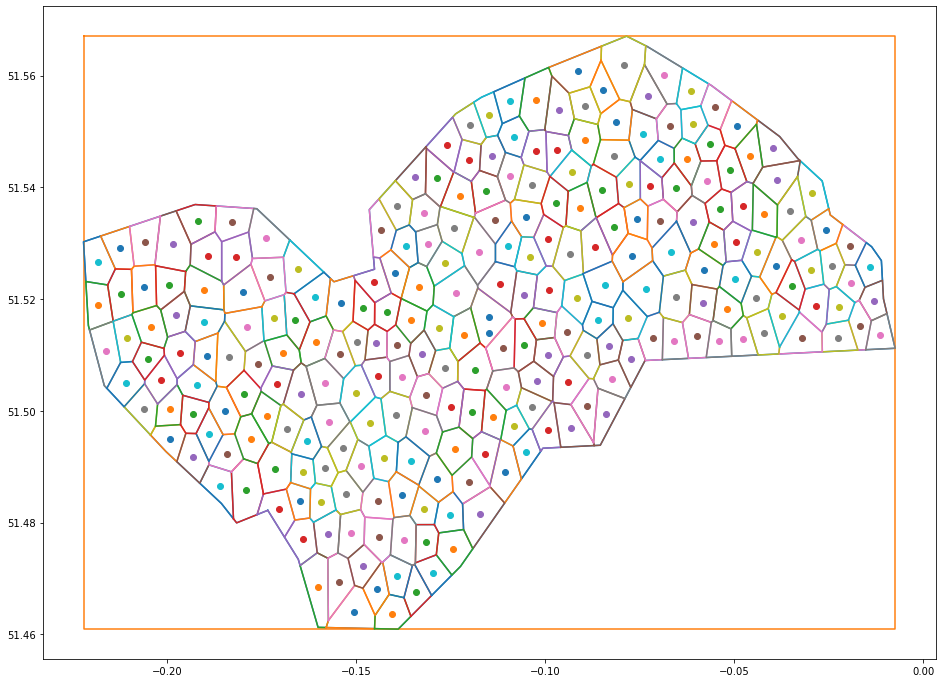

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
grid_partitioning = Partitioning(CITY_BOUNDS_FILE,
                                 cell_width=config["cell_width"],
                                 voronoi=config["voronoi"])
config["number_of_grid_elements"] = len(grid_partitioning)
grid_partitioning.plot()

### Create the data loaders

In [21]:
data_loaders, data_set_sizes = get_data_loader(LONDON_PHOTO_DIR, grid_partitioning,
                                               config["train_batch_size"],
                                               config["test_batch_size"],
                                               IMAGENET_MEAN,
                                               IMAGENET_STD,
                                               brightness = config["augmentation"]["color_jitter"]["brightness"],
                                               contrast = config["augmentation"]["color_jitter"]["contrast"],
                                               saturation = config["augmentation"]["color_jitter"]["saturation"],
                                               hue = config["augmentation"]["color_jitter"]["hue"],
                                               distortion_scale = config["augmentation"]["random_perspective"]["distortion_scale"],
                                               p=config["augmentation"]["random_perspective"]["p"])

In [14]:
## Train on the grid output

# resnet50 = models.resnet50(pretrained=True, progress=True)
# resnet50.to(device)
# resnet50 = lock_layers(resnet50, (3, 224, 224), config["lock_factor"])
# resnet50.fc = nn.Linear(resnet50.fc.in_features, config["number_of_grid_elements"])
# resnet50.to(device)
# print(config["lock_factor"])
# summary(resnet50, (3, 224, 224))

In [8]:
def setup_and_train():
    with wandb.init(project="CV-GeoGuessr", entity="cv-geoguessr", config={**config}) as run:
        wandbconfig = wandb.config

        SESSION = wandb.run.name
        BASE_FOLDER = "./checkpoints"
        CHECKPOINT_FOLDER = f'{BASE_FOLDER}/{SESSION}/'

        # Create the model and lock the layers
        resnet50 = models.resnet50(pretrained=True, progress=True)
        resnet50.to(device)
        resnet50 = lock_layers(resnet50, (3, 224, 224), wandbconfig["lock_factor"])
        resnet50.fc = nn.Linear(resnet50.fc.in_features, wandbconfig["number_of_grid_elements"])
        for param in resnet50.fc.parameters():
            param.requires_grad = True

        resnet50.to(device)

        # create the checkpoint folder and save the untrained model
        if not os.path.isdir(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        torch.save(resnet50.state_dict(), CHECKPOINT_FOLDER + "0.ckpt")

        # Define the criterion, optimizer and exp_lr_scheduler
        criterion = nn.CrossEntropyLoss()
        optimizer_ft = optim.SGD(resnet50.parameters(), lr=wandbconfig["lr"], momentum=wandbconfig["momentum"])
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=wandbconfig["lr_decay_step"], gamma=wandbconfig["gamma"])

        # Train the model
        resnet50 = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler, data_loaders,
                       data_set_sizes, grid_partitioning, CHECKPOINT_FOLDER, device, num_epochs=config["epochs"])

In [9]:
config["lock_factor"] = 0.7

setup_and_train()

wandb: Currently logged in as: sjoerdgroot (cv-geoguessr). Use `wandb login --relogin` to force relogin


122/174 layers locked
222/317 params locked
Epoch 0/19
----------
train loss: 5.4255 | accuracy: 0.0091                 
val loss: 5.2641 | accuracy: 0.0150                 
0.00906555090655509	0.015
Epoch 1/19
----------
train loss: 5.1669 | accuracy: 0.0242                 
val loss: 5.0361 | accuracy: 0.0260                 
0.0242080095636581	0.026000000000000002
Epoch 2/19
----------
train loss: 4.9236 | accuracy: 0.0422                 
val loss: 4.8620 | accuracy: 0.0480                 
0.04223948993823471	0.048
Epoch 3/19
----------
train loss: 4.7196 | accuracy: 0.0646                 
val loss: 4.7403 | accuracy: 0.0480                 
0.06455469216975493	0.048
Epoch 4/19
----------
train loss: 4.5371 | accuracy: 0.0844                 
val loss: 4.6340 | accuracy: 0.0565                 
0.08437935843793584	0.0565
Epoch 5/19
----------
train loss: 4.3676 | accuracy: 0.1069                 
val loss: 4.5317 | accuracy: 0.0675                 
0.10689380354652321	0.0675
Epoc

Accuracy/train,▁▁▁▂▂▂▂▃▃▃▄▄▅▅▅▆▇▇██
Accuracy/val,▁▂▃▃▄▅▅▆▆▇▆▆▇▇█▇████
Distance/train,▄▂▁▃▄▅▅▅▅▇▆▇▇▆▇▇██▇█
Distance/val,▂▁▁▃▅▄▅▆▅▇▇█▇█████▇█
Loss/train,█▇▇▇▆▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
Loss/val,█▆▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▂▂▂
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
Accuracy/train,0.62144
Accuracy/val,0.116
Distance/train,0.06859
Distance/val,0.06795


In [19]:
config["lock_factor"] = 0.6

setup_and_train()


105/174 layers locked
189/317 params locked
Epoch 0/19
----------
train loss: 5.5105 | accuracy: 0.0075                 
val loss: 5.4178 | accuracy: 0.0145                 
0.007471607890017932	0.0145
Epoch 1/19
----------
train loss: 5.2922 | accuracy: 0.0238                 
val loss: 5.2031 | accuracy: 0.0210                 
0.023809523809523808	0.021
Epoch 2/19
----------
train loss: 5.0433 | accuracy: 0.0422                 
val loss: 4.9976 | accuracy: 0.0430                 
0.04223948993823471	0.043000000000000003
Epoch 3/19
----------
train loss: 4.8200 | accuracy: 0.0573                 
val loss: 4.8450 | accuracy: 0.0455                 
0.05728232715680415	0.0455
Epoch 4/19
----------
train loss: 4.6161 | accuracy: 0.0787                 
val loss: 4.7390 | accuracy: 0.0585                 
0.07870093644152222	0.0585
Epoch 5/19
----------
train loss: 4.4358 | accuracy: 0.1009                 
val loss: 4.6379 | accuracy: 0.0655                 
0.10091651723450887	0.0655

Accuracy/train,▁▁▁▂▂▂▂▂▃▃▄▄▄▅▅▆▆▇██
Accuracy/val,▁▁▃▃▄▅▅▆▇▇▇▇██████▇▇
Distance/train,▇▃▁▂▂▄▃▄▄▃▅▆▆▆▆▄▇▇█▆
Distance/val,█▂▁▁▂▃▃▄▄▃▄▆▅▆▄▂█▆▆▇
Loss/train,██▇▇▆▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
Loss/val,█▇▅▄▃▃▂▂▁▁▁▁▁▁▁▁▂▂▂▃
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
Accuracy/train,0.65382
Accuracy/val,0.1005
Distance/train,0.06673
Distance/val,0.06696


In [20]:
config["lock_factor"] = 0.8

setup_and_train()

140/174 layers locked
255/317 params locked
Epoch 0/19
----------
train loss: 5.5082 | accuracy: 0.0091                 
val loss: 5.4186 | accuracy: 0.0150                 
0.00906555090655509	0.015
Epoch 1/19
----------
train loss: 5.3099 | accuracy: 0.0250                 
val loss: 5.2191 | accuracy: 0.0255                 
0.02500498107192668	0.025500000000000002
Epoch 2/19
----------
train loss: 5.0927 | accuracy: 0.0360                 
val loss: 5.0506 | accuracy: 0.0275                 
0.035963339310619645	0.0275
Epoch 3/19
----------
train loss: 4.8954 | accuracy: 0.0519                 
val loss: 4.9089 | accuracy: 0.0450                 
0.051902769475991234	0.045
Epoch 4/19
----------
train loss: 4.7282 | accuracy: 0.0698                 
val loss: 4.8025 | accuracy: 0.0460                 
0.06983462841203426	0.046
Epoch 5/19
----------
train loss: 4.5723 | accuracy: 0.0862                 
val loss: 4.7108 | accuracy: 0.0600                 
0.08617254433154015	0.06
Epo

Accuracy/train,▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▆▆▇▇█
Accuracy/val,▁▂▂▃▃▄▅▅▅▆▇▇███▇████
Distance/train,█▂▂▁▂▂▃▂▄▄▄▄▄▄▆▄▅▅▅▆
Distance/val,█▂▁▁▁▂▃▂▄▄▄▃▃▄▆▄▄▅▄▅
Loss/train,██▇▇▆▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
Loss/val,█▇▆▅▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
Accuracy/train,0.5001
Accuracy/val,0.108
Distance/train,0.06734
Distance/val,0.06708


In [21]:
config["lock_factor"] = 0.9

setup_and_train()

157/174 layers locked
285/317 params locked
Epoch 0/19
----------
train loss: 5.5192 | accuracy: 0.0067                 
val loss: 5.4220 | accuracy: 0.0140                 
0.006674636381749353	0.014
Epoch 1/19
----------
train loss: 5.3399 | accuracy: 0.0211                 
val loss: 5.2616 | accuracy: 0.0205                 
0.021119744969117355	0.0205
Epoch 2/19
----------
train loss: 5.1586 | accuracy: 0.0325                 
val loss: 5.1114 | accuracy: 0.0305                 
0.03247658896194461	0.0305
Epoch 3/19
----------
train loss: 4.9922 | accuracy: 0.0448                 
val loss: 4.9892 | accuracy: 0.0350                 
0.04482964734010759	0.035
Epoch 4/19
----------
train loss: 4.8373 | accuracy: 0.0582                 
val loss: 4.8758 | accuracy: 0.0440                 
0.0581789201036063	0.044
Epoch 5/19
----------
train loss: 4.7147 | accuracy: 0.0737                 
val loss: 4.8042 | accuracy: 0.0495                 
0.0737198645148436	0.0495
Epoch 6/19
------

Accuracy/train,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▆▆▇▇▇█
Accuracy/val,▁▂▂▃▃▄▅▅▅▅▆▇▇▇██▇███
Distance/train,█▂▁▁▂▃▄▄▄▅▄▄▃▄▅▄▅▅▆▆
Distance/val,█▃▁▁▃▅▆▄▆▇▅▅▅▅▇▆▇▆▇█
Loss/train,█▇▇▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▁▁
Loss/val,█▇▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
Accuracy/train,0.30743
Accuracy/val,0.0985
Distance/train,0.06694
Distance/val,0.06682


In [22]:
config["lock_factor"] = 0.7

config["augmentation"] = {
        "color_jitter":{
            "brightness": 0,
            "contrast": 0,
            "hue": 0,
            "saturation": 0,
        },
        "random_perspective":{
            "distortion_scale": 0,
            "p": 0
        }
    }

data_loaders, data_set_sizes = get_data_loader(LONDON_PHOTO_DIR, grid_partitioning,
                                               config["train_batch_size"],
                                               config["test_batch_size"],
                                               IMAGENET_MEAN,
                                               IMAGENET_STD,
                                               brightness = config["augmentation"]["color_jitter"]["brightness"],
                                               contrast = config["augmentation"]["color_jitter"]["contrast"],
                                               saturation = config["augmentation"]["color_jitter"]["saturation"],
                                               hue = config["augmentation"]["color_jitter"]["hue"],
                                               distortion_scale = config["augmentation"]["random_perspective"]["distortion_scale"],
                                               p=config["augmentation"]["random_perspective"]["p"])


setup_and_train()

122/174 layers locked
222/317 params locked
Epoch 0/19
----------
train loss: 5.4895 | accuracy: 0.0091                 
val loss: 5.3808 | accuracy: 0.0170                 
0.00906555090655509	0.017
Epoch 1/19
----------
train loss: 5.1874 | accuracy: 0.0326                 
val loss: 5.1506 | accuracy: 0.0330                 
0.03257621040047818	0.033
Epoch 2/19
----------
train loss: 4.8841 | accuracy: 0.0645                 
val loss: 4.9612 | accuracy: 0.0430                 
0.06445507073122136	0.043000000000000003
Epoch 3/19
----------
train loss: 4.6011 | accuracy: 0.0957                 
val loss: 4.8218 | accuracy: 0.0595                 
0.0957362024307631	0.059500000000000004
Epoch 4/19
----------
train loss: 4.3248 | accuracy: 0.1417                 
val loss: 4.6986 | accuracy: 0.0645                 
0.14166168559474	0.0645
Epoch 5/19
----------
train loss: 4.0315 | accuracy: 0.1863                 
val loss: 4.6167 | accuracy: 0.0780                 
0.18629209005778044

Accuracy/train,▁▁▁▂▂▂▃▃▄▅▆▇▇█████
Accuracy/val,▁▂▃▅▅▇▆█▇██▇█▇▇██▇
Distance/train,▅▅▄▄▄▅▅▅▅▅▄▅▅▅▆▃▁█
Distance/val,▇▆▃▅▅▇▆▇▇▇▆▆▇▅▄▁█▄
Loss/train,██▇▇▆▆▆▅▅▄▃▃▂▂▂▁▁▁
Loss/val,█▆▅▄▃▂▂▁▁▁▁▂▂▃▃▃▃▃
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
Accuracy/train,0.9996
Accuracy/val,0.0845
Distance/train,0.08075
Distance/val,0.06448


ZeroDivisionError: division by zero

In [ ]:
sweep_config = {
  "name" : "unlock sweep 3",
  "method" : "grid",
  # "metric" : {
  #     "name" : "Accuracy/val",
  #     "goal" : "maximize"
  # },
  "parameters" : {
    "lock_factor": {
        "values": [0.9, 0.7, 0.6, 0.5]
    },
    # "lr": {
    #     "min" : 0.0005,
    #     "max" : 0.005,
    # },
    # "momentum": {
    #     "min" : 0.7,
    #     "max" : 1.0,
    # },
    # "gamma": {
    #     "min" : 0.0,
    #     "max" : 0.5,
    # },
    # "lr_decay_step": {
    #     "min" : 2,
    #     "max" : 20,
    # },
  }
}


sweep_id = wandb.sweep(sweep_config, project="CV-GeoGuessr", entity="cv-geoguessr")

# count = 10 # number of runs to execute
wandb.agent(sweep_id, function=setup_and_train, project="CV-GeoGuessr", entity="cv-geoguessr")


Create sweep with ID: 9c1z2m2m
Sweep URL: https://wandb.ai/cv-geoguessr/CV-GeoGuessr/sweeps/9c1z2m2m


wandb: Agent Starting Run: 4tlzxwwp with config:
wandb: 	lock_factor: 0.9
wandb: Currently logged in as: sjoerdgroot (cv-geoguessr). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


285/317 params locked
Epoch 0/24
----------
train loss: 5.5076 | accuracy: 0.0069                 
val loss: 5.4404 | accuracy: 0.0155                 
0.006873879258816497	0.0155
Epoch 1/24
----------
train loss: 5.3226 | accuracy: 0.0207                 
val loss: 5.2544 | accuracy: 0.0225                 
0.020721259214983065	0.0225
Epoch 2/24
----------
train loss: 5.1158 | accuracy: 0.0363                 
val loss: 5.1038 | accuracy: 0.0320                 
0.03626220362622036	0.032
Epoch 3/24
----------


## Investigating grid data coverage

In [ ]:
coverage_val = test_coverage(grid_partitioning, data_loaders['val'])
print(coverage_val)


In [ ]:
coverage = test_coverage(grid_partitioning, data_loaders['train'])
print(coverage)

In [ ]:
import numpy as np
data = np.array(coverage)

d = np.diff(np.unique(data)).min()
left_of_first_bin = 0 - float(d)/2
right_of_last_bin = data.max() + float(d)/2

plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
plt.ylabel('Occurrences')
plt.xlabel('Number of test images per cell');
plt.title('Voronoi grid cells')

## Loading an old checkpoint and running metrics

In [32]:
# only works if the loaded model has the same output as the current model
resnet50 = models.resnet50(pretrained=True, progress=True)
resnet50.fc = nn.Linear(resnet50.fc.in_features, config["number_of_grid_elements"])
resnet50.to(device)
MODEL_TO_LOAD_PATH = BASE_FOLDER + "/devout-morning-26/epoch_19.ckpt"
resnet50 = load_model(resnet50, MODEL_TO_LOAD_PATH, config["lock_factor"], device)

174/174 layers locked
317/317 params locked


In [ ]:
# now train with the loaded model with more layers unlocked

# optimizer_ft = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)
# resnet50 = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=config["epochs"])


In [33]:
confusion_matrix, samples = create_confusion_matrix(resnet50, grid_partitioning, data_loaders['val'], False, device)
print(confusion_matrix.to('cpu'))

tensor([[ 53.1311,   6.0628,  33.8177,  ...,  19.4430, -31.3702,  -4.7120],
        [  1.2831,  32.0090,  11.0174,  ...,   1.0909,  15.7390,  19.8873],
        [ 15.9484,  15.8024,  20.3416,  ...,  12.7018, -19.4879, -10.1023],
        ...,
        [ 14.4602,  -2.5167,  10.8301,  ...,  30.2763,  -9.4559,  -2.7111],
        [  6.0698,   7.1403,  -1.7203,  ...,  -3.0191,  32.2894,  21.3183],
        [  3.7366,   7.6055,   2.8148,  ...,  -3.2060,  16.4762,  16.3626]])


In [ ]:
plot_confusion_matrix(confusion_matrix)

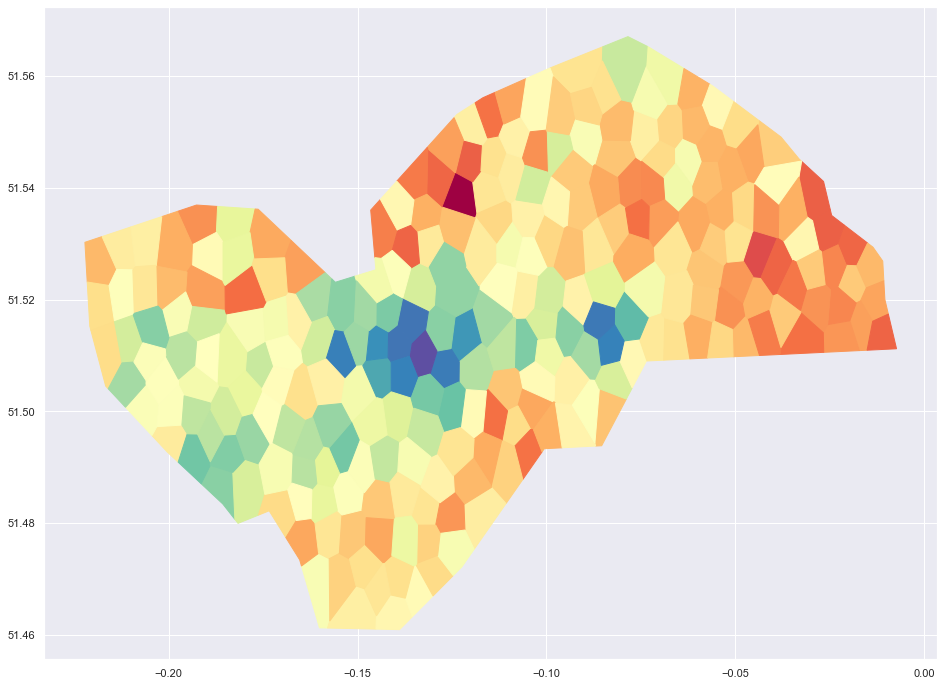

In [34]:
i = 0
p_min = torch.min(confusion_matrix[i, :])
p_max = torch.max(confusion_matrix[i, :])
pred_cell_i = 1 - (confusion_matrix[i, :] - p_min) / (p_max - p_min)
plt.figure(figsize=(16,12))
grid_partitioning.plot_prediction(pred_cell_i)

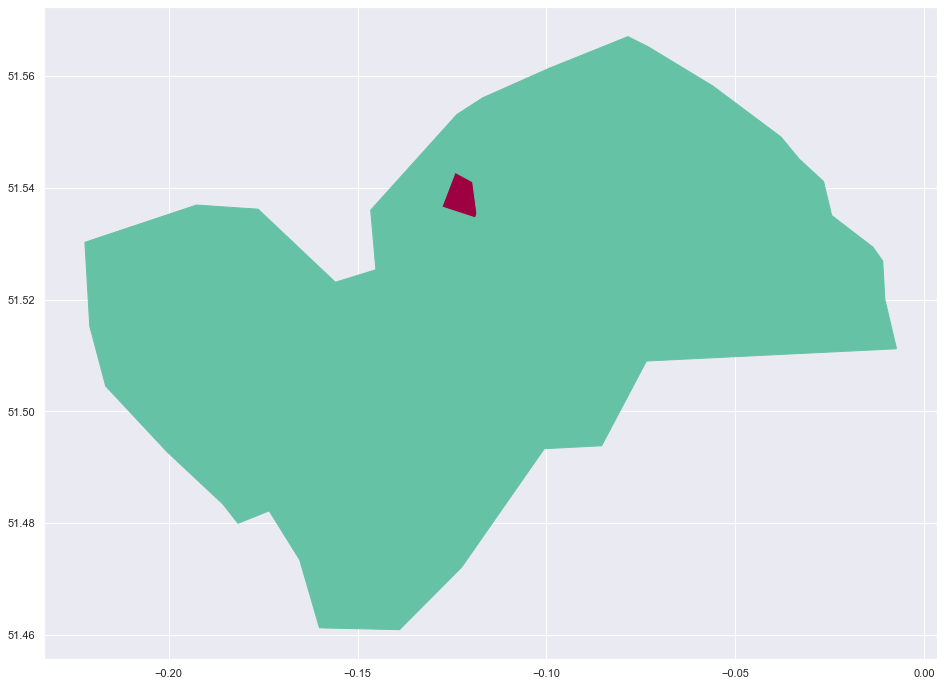

In [30]:
plt.figure(figsize=(16,12))
grid_partitioning.plot_prediction([0.8 if x != i else 0 for x in range(252)])


### Generating grid cell code for p5js visualisation

In [35]:
c_min = torch.min(confusion_matrix)
c_max = torch.max(confusion_matrix)


for i, cell in enumerate(grid_partitioning.cells):
    print(f'nodes.push(new Node({i}, {cell.centroid.x}, {cell.centroid.y},[', end="")
    for vertex in cell.exterior.coords:
        print('{x:' + str(round(vertex[0], 6)) + ', y:' + str(round(vertex[1], 6)) + '},', end="")
        pass
    print(f'], [', end="")
    for val in confusion_matrix[i, :]:
        print(f"{round(float((val.item()-c_min) / (c_max - c_min)), 3)}, ", end='')
        pass
    print(']))')

print('')

nodes.push(new Node(0, -0.12256201376676056, 51.53843008254098,[{x:-0.119529, y:51.541087},{x:-0.118406, y:51.535405},{x:-0.118742, y:51.534718},{x:-0.118853, y:51.534637},{x:-0.127678, y:51.536591},{x:-0.124193, y:51.542743},{x:-0.124091, y:51.542767},{x:-0.119529, y:51.541087},], [0.798, 0.484, 0.669, 0.491, 0.511, 0.467, 0.462, 0.643, 0.456, 0.264, 0.145, 0.284, 0.42, 0.462, 0.299, 0.247, 0.108, 0.237, 0.584, 0.488, 0.434, 0.605, 0.605, 0.527, 0.657, 0.53, 0.619, 0.667, 0.557, 0.667, 0.331, 0.225, 0.327, 0.379, 0.237, 0.538, 0.58, 0.502, 0.64, 0.519, 0.645, 0.436, 0.575, 0.466, 0.557, 0.471, 0.547, 0.246, 0.393, 0.458, 0.328, 0.66, 0.589, 0.633, 0.355, 0.57, 0.324, 0.415, 0.238, 0.472, 0.4, 0.332, 0.504, 0.211, 0.228, 0.475, 0.537, 0.612, 0.462, 0.553, 0.404, 0.576, 0.328, 0.583, 0.587, 0.662, 0.6, 0.617, 0.556, 0.469, 0.499, 0.417, 0.436, 0.572, 0.464, 0.501, 0.406, 0.325, 0.267, 0.462, 0.444, 0.438, 0.459, 0.438, 0.626, 0.577, 0.442, 0.588, 0.273, 0.238, 0.322, 0.457, 0.509, 0.395